### IMPORTS

In [12]:
# IMPORTING NECESSARY MODULES
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import mrcnn.utils
import cv2 as cv
import os
import skimage.io
import numpy as np
import pickle
from lib.visualizer import show_images
from lib.homography import find_homography
import csv

import tensorflow as tf
print('Tensorflow Version: ',tf.__version__)
import h5py
print('h5py Version: ',h5py.__version__)


# FEW DIRECTORIES
MODEL_DIR = './logs/mask_RCNN_logs/'
COCO_MODEL_PATH = './data/weights/mask_rcnn_coco.h5'
DATA_DIR = './data/aoa_data'
RESULTS_DIR = './results/images'
PIXEL_DIR = './results/pixels/'


# Class Names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# CALIBRATION MATRIX FOR POINTS CALIBRATION
calibration_matrix = np.array([ [ 1,0,0],[0,1,0],[0,0,1]])


# RANDOM COLORS
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[75, 200, 214],[202, 241, 109],[223, 117, 230],[138, 135, 243]]

Tensorflow Version:  2.2.0
h5py Version:  2.10.0


### MASK RCNN

In [ ]:
class InferenceConfig(mrcnn.config.Config):
    # Name of the Configuration
    NAME = 'coco_inference'

    # GPU Parameters
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of class = number of classes +1(Background)
    NUM_CLASSES = len(class_names)

config = InferenceConfig()

# Initialize the Mask R-CNN model for inference and then load the weights.
model = mrcnn.model.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load the weights into the model.
model.load_weights(filepath=COCO_MODEL_PATH, by_name=True)

***DEMO***

In [ ]:
file_name = './data/demo/mask_RCNN.jpg'
image = skimage.io.imread(file_name)


# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=1)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                boxes=r['rois'], 
                                masks=r['masks'], 
                                class_ids=r['class_ids'], 
                                class_names=class_names, 
                                scores=r['scores'])

# VISUALIZING ONLY THE BOTTLES
bottle_index = np.array([i for (i, item) in enumerate(r['class_ids']) if class_names[item]=='bottle' ])
mrcnn.visualize.display_instances(image, r['rois'][bottle_index], r['masks'][:,:,bottle_index],r['class_ids'][bottle_index] , 
                            class_names, r['scores'][bottle_index],save_fig_path = './results/demo/mask_RCNN.jpg')

***MASK RCNN Model Detection***

In [ ]:
threshold = 300*400
for i in os.listdir(DATA_DIR):
    if i.split('.')[-1] != 'jpg':
        continue
    print(os.path.join(DATA_DIR,i))
    image = cv.imread(os.path.join(DATA_DIR,i))
    results = model.detect([image],verbose = 0)
    r = results[0]
    arr = np.array([i for (i, mask) in enumerate(r['masks'].T) if np.count_nonzero(mask)< threshold])
    r['rois'] = r['rois'][arr]
    r['masks'] = r['masks'][:,:,arr]
    r['class_ids'] = r['class_ids'][arr]
    r['scores'] = r['scores'][arr]

    with open(MODEL_DIR+i.split('.')[0]+".pkl","wb") as fw:
        pickle.dump(r,fw)

### CALIBRATION

In [29]:
ALPHA = 4
points = []

def mouse_callback(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x*ALPHA,y*ALPHA])

f = open('./data/evaluation/calibration/paper.csv','w',newline="")   # APPEND - "a" or REWRITE - "w"
writer = csv.writer(f)


count = 0
with open("./data/evaluation/calculation/paper.txt", "r") as file:
    for line in file:
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        print(f"\n\nCASE {count}: {CASE}")
        count = count + 1

        
        image = cv.imread(os.path.join(DATA_DIR, f"{CASE}_{L1}.jpg"))
        assert image is not None
        image_ = cv.resize(image,(int(image.shape[1]/ALPHA),int(image.shape[0]/ALPHA)))


        for i in os.listdir(os.path.join(PIXEL_DIR,f"{CASE}_{L1}")):    
            src_pt = np.loadtxt(os.path.join(PIXEL_DIR,f"{CASE}_{L1}",i), delimiter=',',max_rows=1).astype(int)
            print(i.split('.')[0])
            print(f"AoA Center: {src_pt}\n")
            cv.namedWindow('CALIBRATION')
            cv.setMouseCallback('CALIBRATION', mouse_callback)
            cv.imshow('CALIBRATION', image_)
            cv.waitKey(0)
            dst_pt = points[-1]
            
            tux = (src_pt[0],src_pt[1],dst_pt[0],dst_pt[1])
            writer.writerow(tux)
    f.close()



CASE 0: paper
80_6F_B0_EE_9C_67
AoA Center: [3504 1585]

80_6F_B0_EE_AA_13
AoA Center: [1688 1293]

80_6F_B0_EE_AD_32
AoA Center: [3034 1323]



### VISUALIZING POINTS

In [8]:
def visualize_points(CASE, level, METHOD = 'POINTS',mask_RCNN = False):
    image = cv.imread(os.path.join(DATA_DIR, f"{CASE}_{level}.jpg"))
    assert image is not None

    file_count = 0

    for i in os.listdir(os.path.join(PIXEL_DIR,f"{CASE}_{level}")):
        file_count = file_count + 1
        color = colors[file_count-1]
        cv.putText(image, i.split('.')[0], (image.shape[1]-1000, file_count*100),cv.FONT_HERSHEY_DUPLEX, 2, color, 2, cv.LINE_AA)
        
        
        center_pt = np.loadtxt(os.path.join(PIXEL_DIR,f"{CASE}_{level}",i), delimiter=',',max_rows=1).astype(int)
        center_pt = np.hstack((center_pt,[1]))
        calibrated_pt = calibration_matrix@center_pt.T
        calibrated_pt = (calibrated_pt[:2]/calibrated_pt[2]).astype('int')
        if METHOD == 'CENTERS':
            cv.circle(image, calibrated_pt, 50, color, 30)
            continue


        pts = np.loadtxt(os.path.join(PIXEL_DIR,f"{CASE}_{level}",i), delimiter=',',usecols=(0,1),skiprows=1).astype(int)
        if len(pts) and pts.ndim == 1:
            pts = np.array([pts])
        elif pts.ndim != 2:
            continue
        pts = np.hstack((pts, np.ones((pts.shape[0],1))))
        c_pts = np.dot(calibration_matrix,pts.T).T
        c_pts = (c_pts[:,:2]/c_pts[:,2:]).astype(int)
        counter = 0
        hull = cv.convexHull(c_pts)
        for item in c_pts:
            if METHOD == 'POINTS':
                cv.drawMarker(image, (item[0],item[1]), color, markerType=cv.MARKER_STAR,markerSize=40, thickness=2, line_type=cv.LINE_AA)
            else:
                cv.drawContours(image,[hull],0,color,-1)

    if mask_RCNN:
        with open(os.path.join(MODEL_DIR, f"{CASE}_{level}.pkl"), 'rb') as f:
            r = pickle.load(f)

        bottle_index = np.array([i for (i, item) in enumerate(r['class_ids']) if class_names[item]=='bottle' ])
        mrcnn.visualize.display_instances(image, r['rois'][bottle_index], r['masks'][:,:,bottle_index],r['class_ids'][bottle_index] , class_names, r['scores'][bottle_index],save_fig_path = os.path.join(RESULTS_DIR,f"{CASE}_{level}.jpg"))
    
    else:
        return [image,'c',f"{CASE} - {level}"]

***Paper***

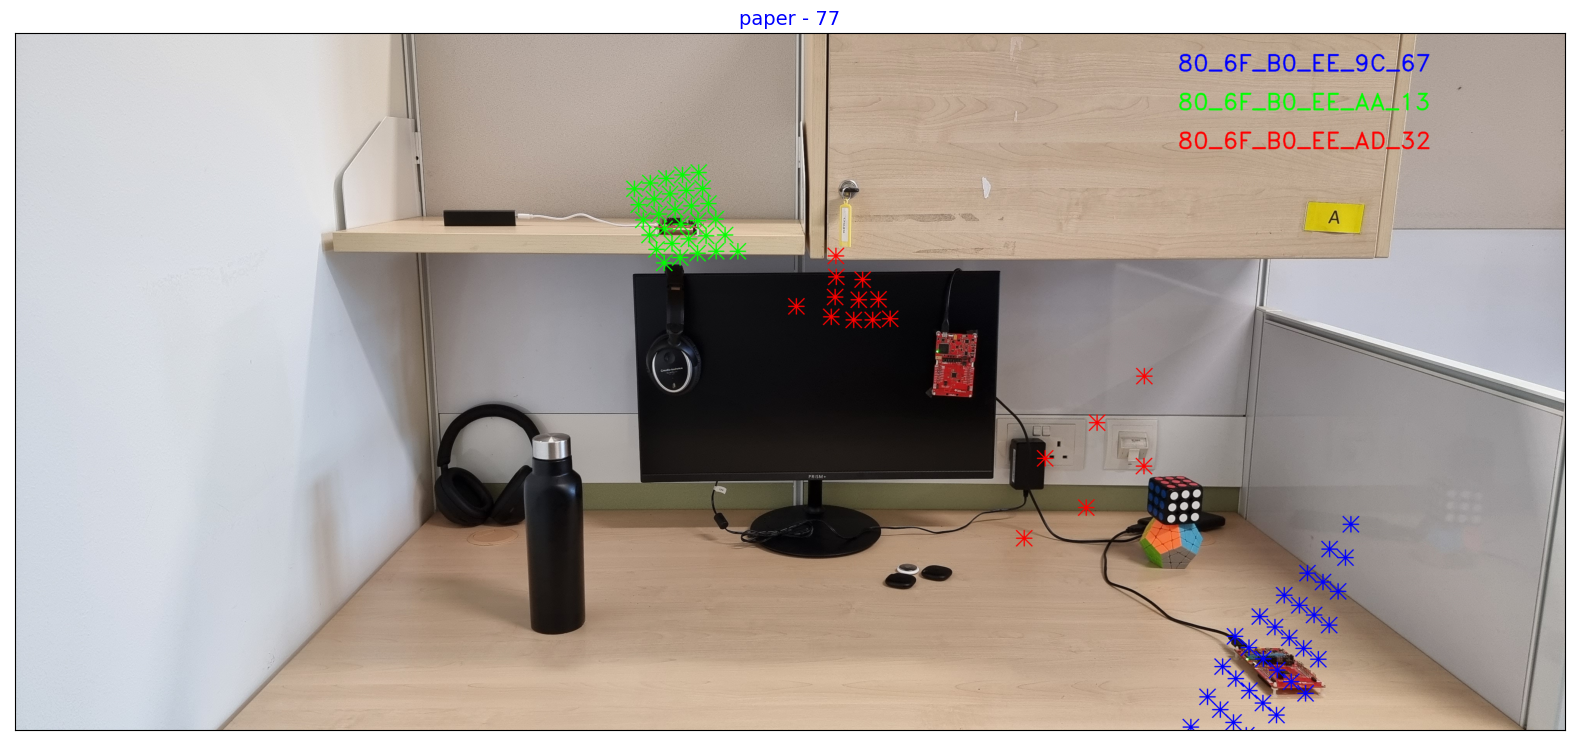

In [45]:
src_pts = np.loadtxt('./data/evaluation/calibration/paper.csv', delimiter=',',usecols=[0,1]).astype(int)   
dst_pts = np.loadtxt('./data/evaluation/calibration/paper.csv', delimiter=',',usecols=[2,3]).astype(int)                                
calibration_matrix,_ = cv.estimateAffinePartial2D(src_pts,dst_pts)
calibration_matrix = np.vstack((calibration_matrix,[[0,0,1]]))

show_images([visualize_points('paper',77,"POINTS")],size = 20)

***SINGLE SLAVE***

In [ ]:
images = []



src_pts = np.loadtxt('./data/weights/single_slave.csv', delimiter=',',usecols=[0,1]).astype(int)   
dst_pts = np.loadtxt('./data/weights/single_slave.csv', delimiter=',',usecols=[2,3]).astype(int)                                
calibration_matrix,_ = cv.estimateAffinePartial2D(src_pts,dst_pts)
calibration_matrix = np.vstack((calibration_matrix,[[0,0,1]]))

with open("./data/weights/single_slave.txt", "r") as file:
    for line in file:
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        image = visualize_points(CASE,L1,'CENTERS')
        images.append(image)
print(len(images))

# PICK HOW MANY IMAGES YOU WANT TO BE SIDE BY SIDE
n = 5
for i_count in range(len(images)//n):
    show_images(images[i_count*n:i_count*n+n],size= 3)
if len(images)%n:
    show_images(images[(i_count+1)*n:(i_count+1)*n+ len(images)%n],size = 3)

***TWO SLAVE***

In [ ]:
src_pts = np.loadtxt('./data/weights/two_slave.csv', delimiter=',',usecols=[0,1]).astype(int)   
dst_pts = np.loadtxt('./data/weights/two_slave.csv', delimiter=',',usecols=[2,3]).astype(int)                                
calibration_matrix,_ = cv.estimateAffinePartial2D(src_pts,dst_pts)
calibration_matrix = np.vstack((calibration_matrix,[[0,0,1]]))

images = []
with open("./data/weights/two_slave.txt", "r") as file:
    for line in file:
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        image = visualize_points(CASE,L1,'POINTS')
        images.append(image)
print(len(images))

# PICK HOW MANY IMAGES YOU WANT TO BE SIDE BY SIDE
n = 5
for i_count in range(len(images)//n):
    show_images(images[i_count*n:i_count*n+n],size = 3)
if len(images)%n:
    show_images(images[(i_count+1)*n:(i_count+1)*n+ len(images)%n],size = 3)

***THREE SLAVE***

In [ ]:
src_pts = np.loadtxt('./data/weights/three_slave.csv', delimiter=',',usecols=[0,1]).astype(int)   
dst_pts = np.loadtxt('./data/weights/three_slave.csv', delimiter=',',usecols=[2,3]).astype(int)                                
calibration_matrix,_ = cv.estimateAffinePartial2D(src_pts,dst_pts)
calibration_matrix = np.vstack((calibration_matrix,[[0,0,1]]))

images = []
with open("./data/weights/three_slave.txt", "r") as file:
    for line in file:
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        image = visualize_points(CASE,L1,'POINTS')
        images.append(image)
print(len(images))

# PICK HOW MANY IMAGES YOU WANT TO BE SIDE BY SIDE
n = 5
for i_count in range(len(images)//n):
    show_images(images[i_count*n:i_count*n+n],size= 5)
if len(images)%n:
    show_images(images[(i_count+1)*n:(i_count+1)*n+ len(images)%n],size= 3)

### EVALUATION

***Destination Points***

In [ ]:
ALPHA = 4
points = []

def mouse_callback(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x*ALPHA,y*ALPHA])

f = open('./results/performance/indoor.csv','w',newline="")   # APPEND - "a" or REWRITE - "w"
writer = csv.writer(f)


count = 0
with open("./data/evaluation/indoor_time.txt", "r") as file:
    for line in file:
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        print(f"\n\nCASE {count}: {CASE}")
        count = count + 1

        
        image = cv.imread(os.path.join(DATA_DIR, f"{CASE}_{L1}.jpg"))
        assert image is not None
        image_ = cv.resize(image,(int(image.shape[1]/ALPHA),int(image.shape[0]/ALPHA)))


        for i in os.listdir(os.path.join(PIXEL_DIR,f"{CASE}_{L1}")):   
            cv.namedWindow('CALIBRATION')
            cv.setMouseCallback('CALIBRATION', mouse_callback)
            cv.imshow('CALIBRATION', image_)
            cv.waitKey(0)
            dst_pt = points[-1]
            
            tux = (dst_pt[0],dst_pt[1])
            writer.writerow(tux)
    f.close()

***Experimental Points***

In [ ]:
f = open('./results/performance/indoor_15.csv','w',newline="")
writer = csv.writer(f)

src_pts = np.loadtxt('./data/evaluation/time_analysis.csv', delimiter=',',usecols=[0,1]).astype(int)   
dst_pts = np.loadtxt('./data/evaluation/time_analysis.csv', delimiter=',',usecols=[2,3]).astype(int)                                
calibration_matrix,_ = cv.estimateAffinePartial2D(src_pts,dst_pts)
calibration_matrix = np.vstack((calibration_matrix,[[0,0,1]]))


count = 0
with open("./data/evaluation/indoor_time.txt", "r") as file:
    for line in file:
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        print(f"\n\nCASE: {CASE}")
        show_images([visualize_points(CASE,L1,'POINTS')])
        
        image = cv.imread(os.path.join(DATA_DIR, f"{CASE}_{L1}.jpg"))
        assert image is not None

        for i in os.listdir(os.path.join(PIXEL_DIR,f"{CASE}_{L1}")):      
            print(i.split('.')[0])
            src_pt = np.loadtxt(os.path.join(PIXEL_DIR,f"{CASE}_{L1}",i), delimiter=',',max_rows=1).astype(int)
            src_pt = np.hstack((src_pt,[1]))
            calibrated_pt = calibration_matrix@src_pt.T
            calibrated_pt = (calibrated_pt[:2]/calibrated_pt[2]).astype('int')
            print(f"AOA_CENTER: {calibrated_pt}")

            tux = (calibrated_pt[0],calibrated_pt[1])
            writer.writerow(tux)
            count = count + 1
            print(count)
    f.close()

### MATCHING IDEA

***MATCHING IDEA FROM PREVIOUS STUDENT***

In [ ]:
# PIXEL PROXIMITY BASED MATCHING TECHNIQUE
def pixel_proximity_matcher(CASE,level):
    image = cv.imread(os.path.join(DATA_DIR, f"{CASE}_{level}.jpg"))
    assert image is not None
    file_count = 0

    # loading the mask_RCNN output
    with open(os.path.join(MODEL_DIR,f"{CASE}_{level}.pkl"), 'rb') as f:
        r = pickle.load(f)

    masks = r['masks']
    scores = r['scores']
    num_objects = len(scores)

    POINTS_PATH = os.path.join(PIXEL_DIR,f"L{level}")
    for i in os.listdir(POINTS_PATH):
        color = colors[file_count]
        file_count = file_count + 1
        cv.putText(image, i.split('.')[0], (image.shape[1]-1000, file_count*100),cv.FONT_HERSHEY_DUPLEX, 2, color, 2, cv.LINE_AA)

        pts = np.loadtxt(os.path.join(POINTS_PATH,i), delimiter=',',usecols=(0,1),skiprows=1).astype(int)
        cts = np.loadtxt(os.path.join(POINTS_PATH,i), delimiter=',',usecols=(2),skiprows=1).astype(int)

        pts = np.hstack((pts, np.ones((pts.shape[0],1))))
        c_pts = np.dot(calibration_matrix,pts.T).T
        c_pts = (c_pts[:,:2]/c_pts[:,2:]).astype(int)

        if len(pts) and pts.ndim == 1:
            pts = np.array([pts])
        elif pts.ndim != 2:
            continue

        final_score = np.zeros(num_objects)
        now_masks = []

        for i in range(num_objects):
            mask = masks[:,:,i]
            count = 0
            size = np.where(mask)[0].shape[0]
            for p,coordinate in enumerate(c_pts):
                x,y = coordinate
                if(x>=4000) or(x<0) or y>3000 or y<0:
                    continue
                if mask[y,x]:
                    count += cts[p]
            else:
                final_score[i] = count/size * scores[i]
                now_masks.append(mask)
    
        k = np.argmax(final_score)
        mask = masks[:, :, k]
        r["final_mask"] = mask
        image[mask] = color
        # mask = np.dstack((color[0]*mask,color[1]*mask, color[2]*mask)).astype(np.uint8)
        # image = cv.addWeighted(image,1,mask,1,0)

        # cv.imwrite(os.path.join(RESULTS_DIR,CASE+f'{file_count}.jpg'), img4)
        # r["masks"] = now_masks
        # r["final_score"] = final_score
    show_images([[image]],size = 10)
    return "SUCESS"

In [ ]:
pixel_proximity_matcher('three_top_indoor_i',63)

***Matching Function-Homography***

In [ ]:
# HOMOGRAPHY BASED MATCHING TECHNIQUE

# FINDING L2 NORM BASED SIMILARITY BETWEEN TWO NUMPY ARRAYS
def find_l2_norm(arr1,arr2):
    return np.sum((arr1-arr2)**2)


# BEST MATCH
def find_best_match(ARR, ARRs):
    min_distance = None
    match_index = 0
    for i,arr in enumerate(ARRs):
        if min_distance is None or min_distance>find_l2_norm(arr,ARR):
            min_distance = find_l2_norm(arr,ARR)
            match_index = i
    return match_index

# FINDING THE CONVEX HULL MASK AROUND A SET OF POINTS
def find_mask(SLAVE,LEVEL,SHAPE=(3000,4000)):
        pts = np.loadtxt(os.path.join(PIXEL_DIR,f"L{LEVEL}",SLAVE), delimiter=',',usecols=(0,1)).astype(int)
        if len(pts) and pts.ndim == 1:
            pts = np.array([pts])
        elif pts.ndim != 2:
            return None
        pts = np.hstack((pts, np.ones((pts.shape[0],1))))
        c_pts = np.dot(calibration_matrix,pts.T).T
        c_pts = (c_pts[:,:2]/c_pts[:,2:]).astype(int)
        hull = cv.convexHull(c_pts)
        hull_mask = np.zeros(SHAPE).astype('uint8')
        cv.fillPoly(hull_mask, [hull], 255)
        return hull_mask


def homography_estimation_mask(CASE,LEVEL1,LEVEL2,matching_order=None):
    c_image1 = cv.imread(os.path.join(DATA_DIR, CASE+"_"+str(LEVEL1)+'.jpg'))
    c_image2 = cv.imread(os.path.join(DATA_DIR, CASE+"_"+str(LEVEL2)+'.jpg'))
    assert c_image1 is not None
    assert c_image2 is not None
    image1, image2 = cv.cvtColor(c_image1, cv.COLOR_BGR2GRAY), cv.cvtColor(c_image2,cv.COLOR_BGR2GRAY)

    # loading the mask_RCNN output
    with open(os.path.join(MODEL_DIR,CASE+"_"+str(LEVEL1)+'.pkl'), 'rb') as f:
        r1 = pickle.load(f)
    with open(os.path.join(MODEL_DIR,CASE+"_"+str(LEVEL2)+'.pkl'), 'rb') as f:
        r2 = pickle.load(f)
    
    h_arr = []
    for i in range(len(r1['class_ids'])):
        mask1 = r1['masks'][:,:,i]
        mask1 = np.where(mask1, 255, 0).astype("uint8")
        mask1 = cv.bitwise_and(image1,image1, mask=mask1)
        if matching_order is None:
            mask2 = r2['masks'][:,:,i]
            mask2 = np.where(mask2 ,255, 0).astype("uint8")
            mask2 = cv.bitwise_and(image2,image2, mask=mask2)
            show_images([[mask1],[mask2]],size=2)
            continue
        else:
            mask2 = r2['masks'][:,:,matching_order[i]]
            mask2 = np.where(mask2 ,255, 0).astype("uint8")
            mask2 = cv.bitwise_and(image2,image2, mask=mask2)
        H = find_homography(mask1,mask2)
        if H is not None:
            h_arr.append(H)
        else:
            h_arr.append(np.zeros((3,3)))
    assert matching_order is not None

    
    POINTS_PATH = os.path.join(PIXEL_DIR,f"L{LEVEL1}")
    file_count = 0
    for i in os.listdir(POINTS_PATH):

        color = colors[file_count]
        file_count = file_count + 1

        cv.putText(c_image1, i.split('.')[0], (c_image1.shape[1]-1000, file_count*100),cv.FONT_HERSHEY_DUPLEX, 2, color, 2, cv.LINE_AA)
        
        mask1 = find_mask(i,LEVEL1,image1.shape[:2])
        mask1 = cv.bitwise_and(image1,image1, mask=mask1)
        mask2 = find_mask(i,LEVEL2,image2.shape[:2])
        mask2 = cv.bitwise_and(image2,image2, mask=mask2)
        
        H = find_homography(mask1, mask2,verbose=True) 
        if H is not None:
            print(i.split('.')[0])
            index = find_best_match(H,h_arr)
            mask = r1['masks'][:,:,index]
            c_image1[mask] = color
    
    show_images([[c_image1]])
       

In [ ]:
homography_estimation_mask('three_top_indoor_i',63,67,matching_order=[0,1,2,3])

***Matching Function - VisBLE***

In [ ]:
print("BOY.... LETS DO IT....!")

***Matching Function- Initiative***

In [ ]:
def match_the_points(case):
    
    # loading the mask_RCNN output
    with open(os.path.join(MODEL_DIR,file_name+'.pkl'), 'rb') as f:
        results = pickle.load(f)
    r = results[0]
    
    threshold = .9
    # Extracting bottles
    bottle_index = np.array([i for (i, item) in enumerate(r['class_ids']) if class_names[item]=='bottle' and r['scores'][i]>threshold ])
    masks = r[masks][bottle_index]

    obj_count = 0
    colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0]]

    for i in os.listdir(PIXEL_DIR):
        obj_count = obj_count + 1
        pts = np.loadtxt(os.path.join(PIXEL_DIR,i), delimiter=',',usecols=(0,1)).astype(int)
        cts = np.loadtxt(os.path.join(PIXEL_DIR,i), delimiter=',',usecols=(2)).astype(int)
        if pts.ndim == 1:
            pts = np.array([pts])
        elif pts.ndim != 2:
            continue
